In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import re
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from functools import reduce
from itertools import combinations
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

#### 전처리
- 불용어 리스트 생성
- 긍부정 분리

In [40]:
df = pd.read_csv("data/중복제거 숙박업소 리뷰.csv")
df.drop('keyword', axis=1, inplace=True)
df.head()

,real_date,hotel,star,review,sentiment
0,20220821,전주 중화산동 Q (Jeonju Junghwasan-dong Q),8.4,사람이많아지고 뭔가 덜청결해지고 좀 부산해진느낌주인분은친절하고조아요,1
1,20230123,전주 신시가지 오스카 (Jeonju Sinsigaji Oscar),4.4,담배낸새가 넘 많이나여,0
2,20230111,전주 신시가지 오스카 (Jeonju Sinsigaji Oscar),6.8,생각보다 깔끔합니다 단지 난방이 없고 전기장판으로 버텨야합니다 아참 불을 다꺼도 예...,1
3,20230601,전주 중화산동 알프스 (Jeonju Junghwadong Alps),8.0,괜찮아요,1
4,20230529,전주 중화산동 알프스 (Jeonju Junghwadong Alps),6.0,방음이 잘 안되서 아쉬웠어요,0


In [41]:
# 불용어 리스트 생성
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt", header=None)[0].tolist()
new_stopwords = ['전주','자주','갠차늠','완전','항상','여조','객리','진짜','묵고', '숙소']

for word in new_stopwords:
    stopwords.append(word)

In [42]:
# 한글과 띄어쓰기가 아닌 경우 없음
df[df['review'].str.contains(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]") == True]

,real_date,hotel,star,review,sentiment


In [43]:
# 긍부정 데이터프레임 생성
pos = df[df['sentiment'] == 1].reset_index(drop=True)
neg = df[df['sentiment'] == 0].reset_index(drop=True)

In [44]:
# 기간별 데이터프레임 생성
df_2021 = df[(df['real_date'] >= 20200602) & (df['real_date'] < 20210602)].reset_index(drop=True)
df_2122 = df[(df['real_date'] >= 20210602) & (df['real_date'] < 20220602)].reset_index(drop=True)
df_2223 = df[(df['real_date'] >= 20220602) & (df['real_date'] < 20230605)].reset_index(drop=True)

In [45]:
# 단어 1차원 리스트
def BoW(df, words = list(), stopwords = list()):
    okt = Okt()
    for i,j  in enumerate(df['review']):
        temp = []
        for w in okt.nouns(j):
            # 1글자 이상의 명사만 & 불용어에 포함되어 있지 않은 경우만
            if (len(w) != 1) and (w not in stopwords):
                temp.append(w)
        text = " ".join(temp)
        words.append(text) #1차원 리스트 생성
        if i % 1000 == 0:
            print(i, "완료")

    # 빈 리스트 삭제
    words = [l for l in words if l]
    return words

In [46]:
# 부정 키워드에 적용 : 단어 1차원 리스트
neg_words = BoW(neg, words=list(), stopwords=stopwords)
neg_words[:5]

0 완료
1000 완료
2000 완료
3000 완료
4000 완료
5000 완료


['담배', '방음', '옛날 여관 느낌', '바닥 체모 세면대 변기 샤워실', '방음 아래 소리']

In [47]:
# 전체 키워드에 적용 : 단어 1차원 리스트
words = BoW(df, words=list(), stopwords=stopwords)
words[:5]

0 완료
1000 완료
2000 완료
3000 완료
4000 완료
5000 완료
6000 완료
7000 완료
8000 완료
9000 완료
10000 완료
11000 완료
12000 완료
13000 완료
14000 완료
15000 완료
16000 완료
17000 완료
18000 완료
19000 완료
20000 완료
21000 완료
22000 완료


['사람 뭔가 느낌 주인', '담배', '생각 난방 전기장판 신분 절대 불빛 침대 한가운데 첮장 침대 머리', '방음', '옛날 여관 느낌']

In [48]:
# 2020년 ~ 2021년 키워드에 적용 : 단어 1차원 리스트
words_2021 = BoW(df_2021, words=list(), stopwords=stopwords)
words_2021[:5]

0 완료
1000 완료
2000 완료


['욕실 침구 거리 여행지 편입 마을 도보 정도 금은 여름 난방 프론트 부탁 응대 해주시 귀차니즘 심해',
 '영화제 얼굴 통화 자로 응대 방도 업그레이드 해주시 캐리어 덕분 영화제',
 '앵두 예약 은행 업그레이드',
 '사실 옥보단 옛날 할머니 느낌',
 '가격 스타']

In [49]:
# 2021년 ~ 2022년 키워드에 적용 : 단어 1차원 리스트
words_2122 = BoW(df_2122, words=list(), stopwords=stopwords)
words_2122[:5]

0 완료
1000 완료
2000 완료
3000 완료


['방이 전반 마음 방음',
 '위치',
 '직원 때문 마음 청소 칫솔 다시 지도 사장 마스크',
 '여행 갑자기 방도',
 '일찍 입실 어서 오라 해주시 퇴실 재촉 기도 객실 아담 객실 전화기']

In [50]:
# 2022년 ~ 2023년 키워드에 적용 : 단어 1차원 리스트
words_2223 = BoW(df_2223, words=list(), stopwords=stopwords)
words_2223[:5]

0 완료
1000 완료
2000 완료
3000 완료
4000 완료
5000 완료
6000 완료
7000 완료
8000 완료
9000 완료
10000 완료
11000 완료
12000 완료
13000 완료
14000 완료
15000 완료
16000 완료


['사람 뭔가 느낌 주인', '담배', '생각 난방 전기장판 신분 절대 불빛 침대 한가운데 첮장 침대 머리', '방음', '옛날 여관 느낌']

In [51]:
def countvec(txt, num):
    vectorizer = CountVectorizer(max_features = num) #가장 많이 언급된 단어 num개 이용
    count = vectorizer.fit_transform(txt) #문서 - 어휘 행렬
    matrix = count.T * count # 어휘 행렬 생성
    matrix.setdiag(0) #대각행렬은 0
    matrix = pd.DataFrame(matrix.toarray(), columns = vectorizer.get_feature_names_out())
    return matrix

In [52]:
neg_matrix = countvec(neg_words, 150)
neg_matrix.head()

,가격,가성,가족,객실,거리,건물,계속,고장,곰팡이,공간,...,편의점,편이,프론트,하루,한번,호텔,화장실,확인,환기,후기
0,0,24,4,36,13,13,7,8,9,7,...,11,16,12,9,10,26,52,7,3,4
1,24,0,3,16,2,2,1,2,3,1,...,7,4,2,10,3,10,23,0,0,5
2,4,3,0,4,4,3,2,0,0,7,...,0,0,1,3,2,8,8,3,1,9
3,36,16,4,0,16,14,28,20,20,7,...,16,15,34,8,15,66,83,28,20,32
4,13,2,4,16,0,7,21,3,1,6,...,12,4,5,4,5,27,31,3,5,10


In [53]:
total_matrix = countvec(words, 150)
total_matrix.head()

,가게,가격,가면,가성,가요,가장,가족,감동,객실,거리,...,토스트,티비,편의점,프론트,하루,한번,해주시,호텔,화장실,후기
0,0,14,1,5,1,3,3,9,7,13,...,3,2,8,1,6,7,4,14,26,17
1,14,0,16,117,18,29,14,7,123,47,...,7,50,48,21,73,21,13,74,150,40
2,1,16,0,8,5,2,19,6,12,8,...,7,5,9,3,7,4,5,22,34,13
3,5,117,8,0,3,15,15,2,65,17,...,7,34,30,4,25,9,21,43,85,21
4,1,18,5,3,0,0,4,3,8,10,...,5,8,6,1,3,4,5,5,14,11


In [54]:
matrix_2021 = countvec(words_2021, 150)
matrix_2021.head()

,가게,가격,가면,가성,가요,가장,가족,감동,감사,객실,...,티비,편의점,하루,한번,할인,해주시,호텔,화장실,후기,힐링
0,0,0,0,1,0,1,1,2,2,3,...,1,2,1,3,1,1,1,5,3,0
1,0,0,1,9,2,1,6,2,0,4,...,2,10,5,2,1,0,8,17,3,2
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,2,1,3,3,0,2
3,1,9,0,0,1,1,9,2,0,5,...,0,2,2,1,0,0,8,12,1,0
4,0,2,0,1,0,0,0,2,0,2,...,1,2,1,1,1,5,0,1,2,3


In [55]:
matrix_2122 = countvec(words_2122, 150)
matrix_2122.head()

,가게,가격,가면,가성,가요,가장,가족,감동,객실,거리,...,티비,펜션,편의점,하루,한번,한복,해주시,호텔,화장실,후기
0,0,3,1,1,0,0,0,4,0,5,...,0,5,2,1,1,0,1,2,5,5
1,3,0,4,11,1,4,1,3,17,15,...,1,1,10,8,2,3,0,11,17,7
2,1,4,0,1,1,0,3,4,3,1,...,0,2,0,4,0,5,0,3,13,3
3,1,11,1,0,1,4,1,0,6,3,...,6,1,3,0,2,1,1,2,13,4
4,0,1,1,1,0,0,3,0,3,1,...,0,1,0,0,1,0,0,1,0,4


In [56]:
matrix_2223 = countvec(words_2223, 150)
matrix_2223.head()

,가게,가격,가면,가성,가요,가장,가족,객실,거리,걱정,...,터미널,티비,편의점,프론트,하루,한번,해주시,호텔,화장실,후기
0,0,11,0,3,1,2,2,4,8,6,...,4,1,4,1,4,3,2,11,16,9
1,11,0,11,97,15,24,7,102,30,24,...,20,47,28,18,60,17,13,55,116,30
2,0,11,0,7,4,2,15,9,7,7,...,1,5,9,3,3,3,4,16,18,10
3,3,97,7,0,1,10,5,54,13,11,...,18,28,25,4,23,6,20,33,60,16
4,1,15,4,1,0,0,1,3,9,2,...,0,7,4,1,2,2,0,4,13,5


In [57]:
def word_sim(matrix): #cosine 유사도 사용
    sim_matrix = pdist(matrix, metric = 'cosine') #pdist : 유클리디안 거리
    sim_matrix = squareform(sim_matrix) # 벡터 > matrix
    vocab = list(matrix.columns) #어휘 리스트

    sims = []
    for i, j in combinations(range(len(vocab)), 2):
        if sim_matrix[i, j] == 0:
            continue
        sims.append((vocab[i], vocab[j], sim_matrix[i, j]))
    sim_list = sorted(sims, key=itemgetter(2), reverse=True) #어휘 유사도 행렬 정렬
    return sim_list

In [58]:
neg_list = word_sim(neg_matrix)
neg_list #유사도 기반

[('대비', '요금', 0.8032439749217329),
 ('대비', '옆방', 0.7881000863595766),
 ('대비', '추가', 0.7876510463719955),
 ('대비', '환기', 0.7737680319948244),
 ('대비', '전화', 0.7651300683467877),
 ('대비', '안내', 0.7627180491213854),
 ('당황', '대비', 0.7602001080356053),
 ('대비', '의자', 0.7543698975446369),
 ('대비', '복도', 0.7533372623485326),
 ('대비', '후기', 0.7493569897589202),
 ('대비', '말씀', 0.7484600742318042),
 ('대비', '새벽', 0.7483828953391093),
 ('대비', '연락', 0.7476457699742404),
 ('대비', '퇴실', 0.7454302260025877),
 ('가격', '대비', 0.7392668074241051),
 ('대비', '절대', 0.7372666940809014),
 ('대비', '카운터', 0.7356321689697329),
 ('대비', '보고', 0.7292319501148254),
 ('대비', '변기', 0.7276341603865543),
 ('대비', '요청', 0.7239446029983296),
 ('대비', '주인', 0.7206088846936367),
 ('대비', '마음', 0.7169400721348685),
 ('계속', '대비', 0.7155477547709117),
 ('대비', '베개', 0.7151376639417997),
 ('담배', '대비', 0.7150161832087336),
 ('대비', '아침', 0.7148504817437503),
 ('대비', '확인', 0.7135369708036667),
 ('대비', '소리', 0.7126356857950829),
 ('담배', '요금', 0.712

In [59]:
total_list = word_sim(total_matrix)
total_list

[('사장', '친절', 0.9786652623579843),
 ('친절', '컨디션', 0.9672974208101937),
 ('방이', '컨디션', 0.9515992994777951),
 ('객실', '친절', 0.9340876906162389),
 ('방이', '사장', 0.932907183579466),
 ('객실', '방이', 0.907878944399097),
 ('사장', '컨디션', 0.9026707854480072),
 ('옆방', '컨디션', 0.8987900100321958),
 ('주인', '친절', 0.8975648860575255),
 ('이용', '친절', 0.8966730172925332),
 ('친절', '프론트', 0.8952979609659372),
 ('미리', '컨디션', 0.8831528744389392),
 ('추억', '컨디션', 0.8738807787149622),
 ('객실', '사장', 0.873399675936414),
 ('방이', '이용', 0.8712109135824491),
 ('구경', '컨디션', 0.8683960616144902),
 ('마당', '컨디션', 0.8652926828194252),
 ('담배', '친절', 0.8651264312247606),
 ('대비', '컨디션', 0.8640182841498713),
 ('사장', '이용', 0.8604621990277932),
 ('스파', '친절', 0.8596379647135354),
 ('새벽', '컨디션', 0.8558198636742527),
 ('감동', '컨디션', 0.8556459521901006),
 ('만원', '친절', 0.8501852197898903),
 ('도착', '컨디션', 0.8472932870719261),
 ('의사', '컨디션', 0.8416691330808528),
 ('이불', '컨디션', 0.8414215548937198),
 ('별로', '컨디션', 0.8391901280083827),
 ('객실',

In [60]:
list_2021 = word_sim(matrix_2021)
list_2021 #유사도 기반

[('담배', '대비', 0.8020337697282476),
 ('담배', '중심', 0.7952633233179415),
 ('대비', '해주시', 0.7815534257068752),
 ('대비', '중심', 0.7801008539632677),
 ('대비', '추가', 0.7729394906541892),
 ('담배', '해주시', 0.7655307725699982),
 ('대비', '무료', 0.7609664343395858),
 ('대비', '친구', 0.75869615755641),
 ('가요', '담배', 0.7573811080357464),
 ('대비', '업그레이드', 0.757273340907837),
 ('대비', '직접', 0.7570428274984916),
 ('담배', '토스트', 0.7564209716361112),
 ('구경', '대비', 0.7552902068104285),
 ('과일', '담배', 0.7549107760303313),
 ('담배', '주오', 0.7526665226575779),
 ('경험', '대비', 0.7502424964196218),
 ('꿀잠', '대비', 0.7500864865939333),
 ('대비', '소리', 0.7500053659536916),
 ('담배', '식당', 0.7499124250730916),
 ('대비', '칫솔', 0.7498385267646513),
 ('꿀잠', '담배', 0.7472888513560623),
 ('대비', '식당', 0.7457994683528798),
 ('대비', '주오', 0.7441963642327454),
 ('감사', '대비', 0.7437456694935749),
 ('담배', '의사', 0.7407837514315223),
 ('대비', '토스트', 0.7404959857738029),
 ('감사', '담배', 0.740406593829957),
 ('대비', '아주머니', 0.7397328947874424),
 ('대비', '보고', 0

In [61]:
list_2122 = word_sim(matrix_2122)
list_2122 #유사도 기반

[('담배', '한복', 0.7622666212854239),
 ('담배', '맛집', 0.7505939943344009),
 ('관광지', '담배', 0.7441531497480255),
 ('기억', '담배', 0.743691696203854),
 ('과일', '담배', 0.7435876363131384),
 ('담배', '옆방', 0.7398570755037205),
 ('담배', '준비', 0.735338213232263),
 ('담배', '추억', 0.7266904982175382),
 ('가요', '담배', 0.7228218572836169),
 ('담배', '덕분', 0.719646182541527),
 ('담배', '지도', 0.7173177866657916),
 ('담배', '해주시', 0.7151871676234642),
 ('담배', '의사', 0.7124882673932003),
 ('담배', '연락', 0.7097781325370862),
 ('기억', '컴퓨터', 0.70558044762313),
 ('컴퓨터', '한복', 0.7021415984988304),
 ('담배', '보일러', 0.7012807388252893),
 ('욕조', '한복', 0.6913703049424561),
 ('대비', '지도', 0.6856514253904349),
 ('담배', '안내', 0.6813586772997751),
 ('담배', '아침', 0.6806701733956846),
 ('지도', '컴퓨터', 0.6792982288554282),
 ('과일', '대비', 0.6765946032272582),
 ('가게', '담배', 0.6760644365927673),
 ('담배', '문자', 0.6759297283495717),
 ('담배', '펜션', 0.6740598315641496),
 ('담배', '한번', 0.6731552241182418),
 ('기억', '대비', 0.6725353699761658),
 ('대비', '한복', 0.672

In [62]:
list_2223 = word_sim(matrix_2223)
list_2223 #유사도 기반

[('사장', '친절', 0.9915369586321211),
 ('친절', '컨디션', 0.9763848567551567),
 ('방이', '사장', 0.9709032277162118),
 ('방이', '컨디션', 0.9639642744092548),
 ('객실', '친절', 0.9603003092364023),
 ('객실', '방이', 0.9436507485350005),
 ('사장', '컨디션', 0.934153911135102),
 ('이용', '친절', 0.9300508073122656),
 ('주인', '친절', 0.9300016396649586),
 ('객실', '사장', 0.9211822424098117),
 ('스파', '친절', 0.92100465312802),
 ('사장', '이용', 0.9201835585265155),
 ('안마', '친절', 0.917210298268691),
 ('친절', '프론트', 0.9152380429139386),
 ('방이', '이용', 0.9136867830819945),
 ('옆방', '컨디션', 0.895446302402684),
 ('별로', '컨디션', 0.8843667418083064),
 ('만원', '친절', 0.8789700520523863),
 ('대비', '컨디션', 0.8769053457511923),
 ('방이', '안마', 0.8761966575505631),
 ('대비', '사장', 0.8742662446675733),
 ('담배', '친절', 0.8686339556061677),
 ('추억', '컨디션', 0.8664751688594707),
 ('새벽', '컨디션', 0.8660441177766244),
 ('의자', '친절', 0.8651712465902333),
 ('객실', '옆방', 0.8639228954485825),
 ('객실', '새벽', 0.8595562652309996),
 ('방이', '프론트', 0.8573348142028316),
 ('방이', '스파', 0

#### Undirected Graph

##### 부정 키워드

In [63]:
# 네트워크 생성
def build_word_sim_undirected(sim_list):
    G = nx.Graph() #undirected graph
    NUM_MAX_WORDS = 150 # 표현 개수 지정
    for word1, word2, sim in sim_list[:NUM_MAX_WORDS]:
        G.add_edge(word1, word2, weight=sim)
    return G

In [64]:
G = build_word_sim_undirected(neg_list)

# 페이지 랭크
pr = nx.pagerank(G) # 페이지 랭크 알고리즘으로 단어의 중요성 추출
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [65]:
# 전반적인 성능 확인 함수
def overall(G = None):
    average_degree = nx.average_degree_connectivity(G)
    clustering_coefficient = nx.average_clustering(G)
    try: #연결 요소가 1개인 경우
        average_path_length = nx.average_shortest_path_length(G)
        
    except: #연결 요소가 여러 개인 경우
        try:
            connected_components = list(nx.connected_components(G))
            for component in connected_components:
                component_graph = G.subgraph(component)
                average_path_length = nx.average_shortest_path_length(component_graph)
        except:
            connected_components = list(nx.strongly_connected_components(G))
            for component in connected_components:
                component_graph = G.subgraph(component)
                average_path_length = nx.average_shortest_path_length(component_graph)
    network_density = nx.density(G)
    network_modularity = nx.algorithms.community.modularity(G, [G.nodes])
    print("Average Degree:", average_degree)
    print("Clustering Coefficient:", clustering_coefficient)
    print("Average Path Length:", average_path_length)
    print("Network Density:", network_density)
    print("Network Modularity:", network_modularity)

In [66]:
# 단어별 중심성 확인 함수
def centrality(G = None):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G)

    degree = pd.DataFrame(degree_centrality, index=[0]).T.reset_index(drop=False)
    between = pd.DataFrame(betweenness_centrality, index=[0]).T.reset_index(drop=False)
    close = pd.DataFrame(closeness_centrality, index=[0]).T.reset_index(drop=False)
    page = pd.DataFrame(pagerank, index = [0]).T.reset_index(drop=False)
    df_list = [degree, between, close, page]
    
    cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)
    cent.columns = ['단어', '연결 중심성', '매개 중심성', '근접 중심성', 'pagerank']
    return cent

In [67]:
overall(G)

Average Degree: {126: 1.3492063492063493, 13: 12.846153846153847, 6: 26.0, 3: 39.333333333333336, 8: 19.875, 1: 124.99107142857143, 2: 68.08333333333333, 4: 37.5}
Clustering Coefficient: 0.09595062990411828
Average Path Length: 2.0095687984496124
Network Density: 0.018168604651162792
Network Modularity: -4.440892098500626e-16


In [68]:
neg_cent = centrality(G)

# 연결 중심성 top 10
neg_cent.sort_values(by = '연결 중심성', ascending=False).iloc[:10,:2]

C:\Users\A\AppData\Local\Temp\ipykernel_24204\4016357353.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)


,단어,연결 중심성
0,대비,0.984375
1,요금,0.101562
4,환기,0.062500
2,옆방,0.046875
25,담배,0.031250
51,최고,0.031250
3,추가,0.023438
39,출장,0.023438
8,의자,0.023438
9,복도,0.023438


In [69]:
neg_cent.sort_values(by = 'pagerank', ascending=False)[['단어', 'pagerank']][:10]

,단어,pagerank
0,대비,0.404618
1,요금,0.031927
4,환기,0.019650
2,옆방,0.015015
25,담배,0.010378
51,최고,0.009977
9,복도,0.008510
3,추가,0.008480
8,의자,0.008301
39,출장,0.007927


In [70]:
neg_cent.sort_values(by = '매개 중심성', ascending=False)[['단어', '매개 중심성']][:10]

,단어,매개 중심성
0,대비,0.990428
1,요금,0.023556
2,옆방,0.005255
8,의자,0.004663
4,환기,0.001318
9,복도,0.000103
3,추가,0.000041
66,무난,0.000041
25,담배,0.000031
51,최고,0.000031


In [71]:
neg_cent.sort_values(by = '근접 중심성', ascending=False)[['단어', '근접 중심성']][:10]

,단어,근접 중심성
0,대비,0.984615
1,요금,0.526749
4,환기,0.516129
2,옆방,0.512000
51,최고,0.507937
25,담배,0.507937
39,출장,0.505929
8,의자,0.505929
9,복도,0.505929
30,크게,0.503937


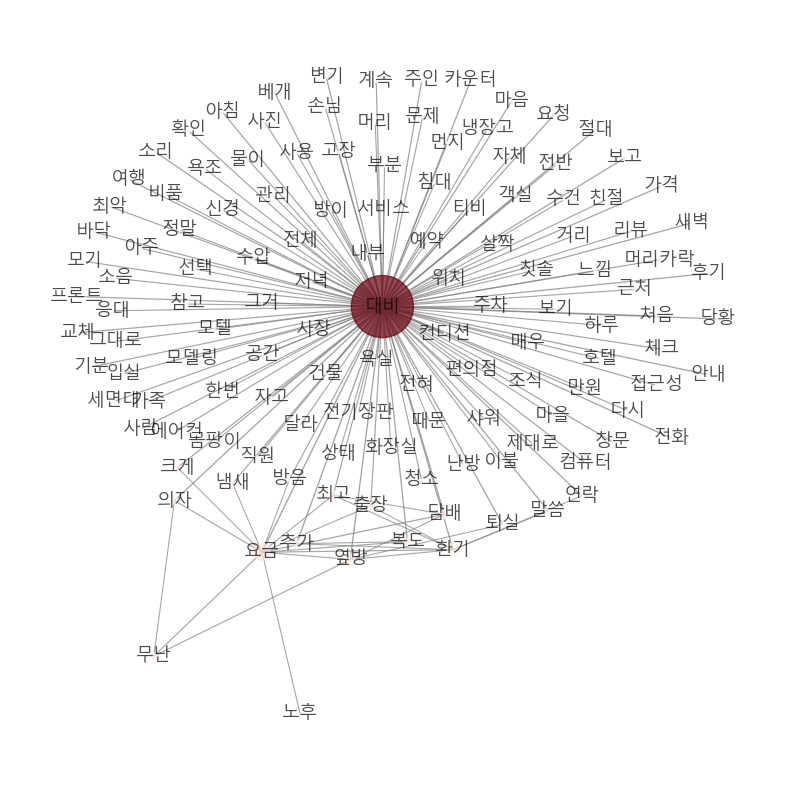

In [72]:
# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

weights = nx.get_edge_attributes(G,'weight').values()
width = [weight / max(weights) for weight in weights]
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos=pos, node_size=nsize, node_color = list(pr.values()), \
                font_family="malgun gothic", with_labels=True, font_size=13, alpha = 0.7, \
                edge_color = '.5', cmap = plt.cm.Reds, width=width)
plt.axis("off")
plt.savefig("image/negative keyword network.png", dpi = 200, bbox_inches = 'tight')

plt.show()

In [73]:
neg[neg['review'].str.contains("대비")==True]

,real_date,hotel,star,review,sentiment
70,20220423,전주한옥마을 덕수궁,9.6,한옥마을 위쪽에 위치해있어요편의점이 가깝고 진짜 화장실이 다른 곳에 비해 넓고 쾌적...,0
90,20210705,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,8.0,가격대비 만족입니다자주 가는 곳입니다,0
91,20210604,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,6.0,어 우선 정말 오래된것 같아요 그냥 가격대비 만족 정도입니다ㅎㅎ,0
138,20200903,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,6.0,가격대비 좋아요,0
144,20200819,전주 중화산동 라베호텔(LABE HOTEL) (Jeonju Junghwasandon...,8.0,화장실 불빛이 너무 희미해서 문닫고 이용하기 무서웠네요ㅠ 그것만 아니면 가격대비 무...,0
...,...,...,...,...,...
5394,20221104,전주 우아동 아미르,9.6,가격 대비 딱 그정도 입니다 생각보다 넓었지만 옛날에 지어진 모텔이여서 그런지 깨끗...,0
5428,20230513,전주 산정동 호텔 하루(HOTEL HARU),6.0,주말에 이 정도 가격 괜찮습니다 다만 인실 말 그대로 인실 고시원 정도의 크기고 오...,0
5467,20200604,전주 금암동 로즈마리,5.0,가격대비 괜찮아요,0
5527,20210604,전주 여지 게스트하우스,8.3,사장님이 친절하셔서 너무 좋았어요 혼숙이 가능한 것도 장점입니다 시설도 깔끔해요 전...,0


##### 전체 키워드

In [74]:
G = build_word_sim_undirected(total_list)

# 페이지 랭크
pr = nx.pagerank(G) # 페이지 랭크 알고리즘으로 단어의 중요성 추출
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [75]:
overall(G)

Average Degree: {7: 23.428571428571427, 29: 6.0344827586206895, 68: 2.426470588235294, 10: 14.1, 32: 3.84375, 3: 39.0, 4: 35.166666666666664, 15: 5.4, 2: 43.910714285714285, 5: 29.7, 1: 58.25}
Clustering Coefficient: 0.12841042550849216
Average Path Length: 2.200547195622435
Network Density: 0.04103967168262654
Network Modularity: -1.1102230246251565e-15


In [76]:
total_cent = centrality(G)

# 연결 중심성 top 10
degree_list = list(total_cent.sort_values(by = '연결 중심성', ascending=False)['단어'][:10])
total_cent.sort_values(by = '연결 중심성', ascending=False).iloc[:10,:2]

C:\Users\A\AppData\Local\Temp\ipykernel_24204\4016357353.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)


,단어,연결 중심성
2,컨디션,0.800000
4,객실,0.376471
1,친절,0.341176
7,이용,0.176471
3,방이,0.117647
0,사장,0.082353
13,담배,0.058824
14,대비,0.058824
18,만원,0.047059
16,새벽,0.047059


In [77]:
# 매개 중심성
between_list = list(total_cent.sort_values(by = '매개 중심성', ascending=False)['단어'][:10])
total_cent.sort_values(by = '매개 중심성', ascending=False)[['단어', '매개 중심성']][:10]

,단어,매개 중심성
2,컨디션,0.747626
1,친절,0.295582
4,객실,0.108232
3,방이,0.028519
7,이용,0.026462
0,사장,0.001866
11,구경,0.001324
20,의사,0.001324
14,대비,0.001324
12,마당,0.001324


In [78]:
# 근접 중심성
close_list = list(total_cent.sort_values(by = '근접 중심성', ascending=False)['단어'][:10])
total_cent.sort_values(by = '근접 중심성', ascending=False)[['단어', '근접 중심성']][:10]

,단어,근접 중심성
2,컨디션,0.833333
1,친절,0.602837
0,사장,0.521472
13,담배,0.515152
14,대비,0.515152
16,새벽,0.512048
18,만원,0.512048
6,주인,0.512048
41,안나,0.508982
42,머리카락,0.505952


In [79]:
# 고유벡터 중심성
eigen_list = list(total_cent.sort_values(by = 'pagerank', ascending=False)['단어'][:10])
total_cent.sort_values(by = 'pagerank', ascending=False)[['단어', 'pagerank']][:10]

,단어,pagerank
2,컨디션,0.226917
1,친절,0.092771
4,객실,0.088455
7,이용,0.040925
3,방이,0.028663
0,사장,0.020745
14,대비,0.014527
13,담배,0.014161
6,주인,0.012102
18,만원,0.011833


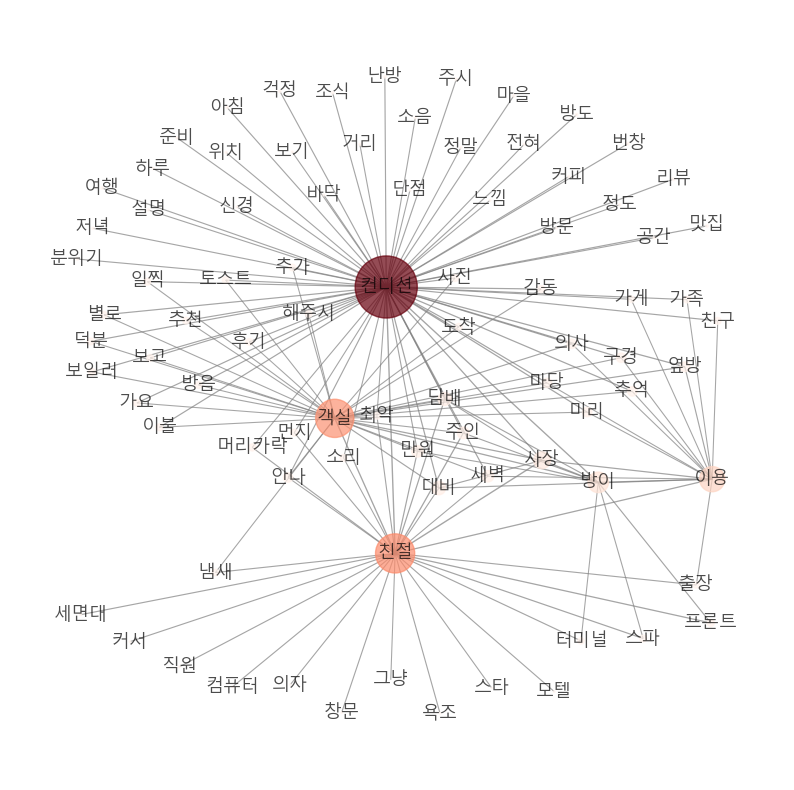

In [80]:
# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

weights = nx.get_edge_attributes(G,'weight').values()
width = [weight / max(weights) for weight in weights]
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos=pos, node_size=nsize, node_color = list(pr.values()), \
                font_family="malgun gothic", with_labels=True, font_size=13, alpha = 0.7, \
                edge_color = '.5', cmap = plt.cm.Reds, width=width)
plt.axis("off")
plt.savefig("image/total keyword network.png", dpi = 200, bbox_inches = 'tight')
plt.show()

##### 기간별

In [81]:
G_2021 = build_word_sim_undirected(list_2021)

# 페이지 랭크
pr = nx.pagerank(G_2021) # 페이지 랭크 알고리즘으로 단어의 중요성 추출
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [82]:
cent_2021 = centrality(G_2021)

# 고유벡터 중심성
eigen_list = list(cent_2021.sort_values(by = 'pagerank', ascending=False)['단어'][:10])
cent_2021.sort_values(by = 'pagerank', ascending=False)[['단어', 'pagerank']][:10]

C:\Users\A\AppData\Local\Temp\ipykernel_24204\4016357353.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)


,단어,pagerank
1,대비,0.319533
0,담배,0.117429
21,아주머니,0.022689
13,주오,0.014433
12,과일,0.009463
35,머리카락,0.008930
56,먼지,0.008690
2,중심,0.007100
3,해주시,0.007003
15,꿀잠,0.006820


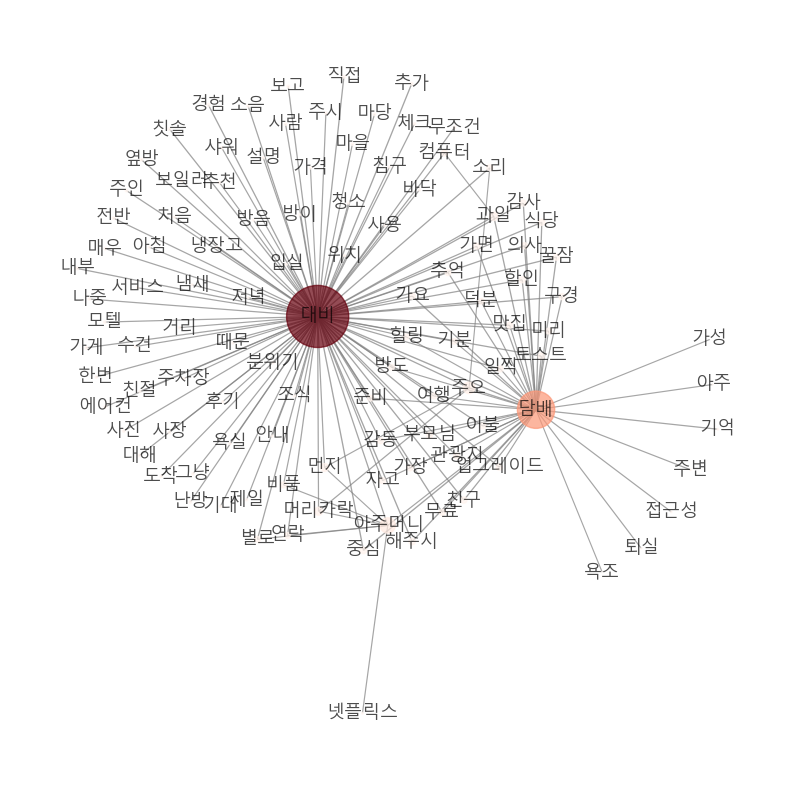

In [83]:
# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

weights = nx.get_edge_attributes(G_2021,'weight').values()
width = [weight / max(weights) for weight in weights]
pos = nx.kamada_kawai_layout(G_2021)

plt.figure(figsize = (10,10))
nx.draw_networkx(G_2021, pos=pos, node_size=nsize, node_color = list(pr.values()), \
                font_family="malgun gothic", with_labels=True, font_size=13, alpha = 0.7, \
                edge_color = '.5', cmap = plt.cm.Reds, width=width)
plt.axis("off")
plt.savefig("image/2020-2021 keyword network.png", dpi = 200, bbox_inches = 'tight')
plt.show()

In [84]:
G_2122 = build_word_sim_undirected(list_2122)

# 페이지 랭크
pr = nx.pagerank(G_2122) # 페이지 랭크 알고리즘으로 단어의 중요성 추출
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [85]:
cent_2122 = centrality(G_2122)

# 고유벡터 중심성
eigen_list = list(cent_2122.sort_values(by = 'pagerank', ascending=False)['단어'][:10])
cent_2122.sort_values(by = 'pagerank', ascending=False)[['단어', 'pagerank']][:10]

C:\Users\A\AppData\Local\Temp\ipykernel_24204\4016357353.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)


,단어,pagerank
0,담배,0.292854
18,대비,0.098476
15,컴퓨터,0.038826
17,욕조,0.025121
4,기억,0.020056
2,맛집,0.013952
6,옆방,0.013869
42,카운터,0.013537
1,한복,0.012263
5,과일,0.011758


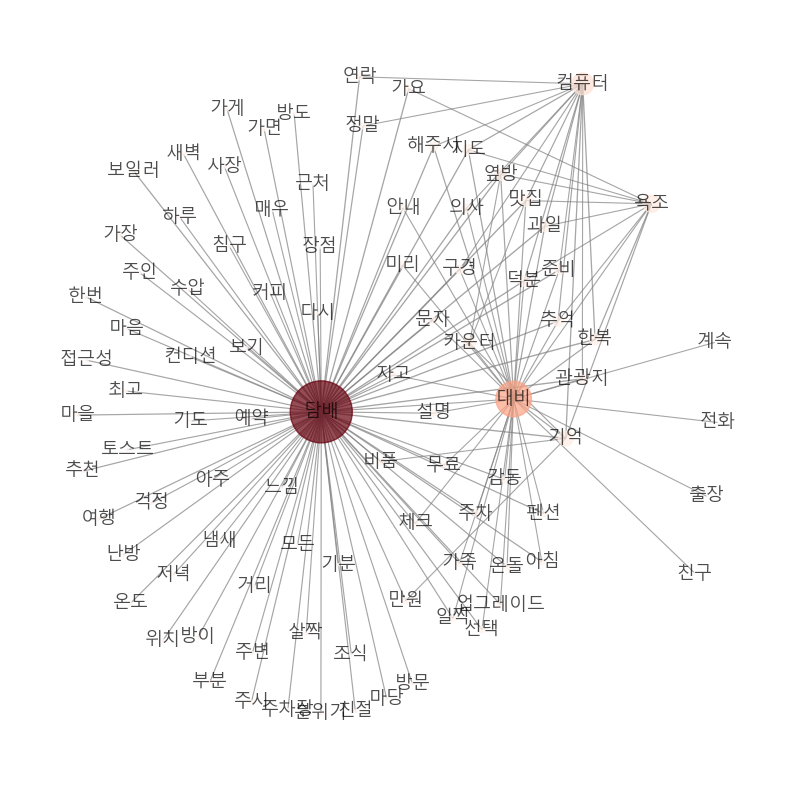

In [86]:
# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

weights = nx.get_edge_attributes(G_2122,'weight').values()
width = [weight / max(weights) for weight in weights]
pos = nx.kamada_kawai_layout(G_2122)

plt.figure(figsize = (10,10))
nx.draw_networkx(G_2122, pos=pos, node_size=nsize, node_color = list(pr.values()), \
                font_family="malgun gothic", with_labels=True, font_size=13, alpha = 0.7, \
                edge_color = '.5', cmap = plt.cm.Reds, width=width)
plt.axis("off")
plt.savefig("image/2021-2022 keyword network.png", dpi = 200, bbox_inches = 'tight')
plt.show()

In [87]:
G_2223 = build_word_sim_undirected(list_2223)

# 페이지 랭크
pr = nx.pagerank(G_2223) # 페이지 랭크 알고리즘으로 단어의 중요성 추출
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

In [88]:
cent_2223 = centrality(G_2223)

# 고유벡터 중심성
eigen_list = list(cent_2223.sort_values(by = 'pagerank', ascending=False)['단어'][:10])
cent_2223.sort_values(by = 'pagerank', ascending=False)[['단어', 'pagerank']][:10]

C:\Users\A\AppData\Local\Temp\ipykernel_24204\4016357353.py:14: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  cent = reduce(lambda x,y : pd.merge(x,y, on = 'index'), df_list)


,단어,pagerank
2,컨디션,0.134706
1,친절,0.128071
4,객실,0.074598
5,이용,0.058510
0,사장,0.058363
3,방이,0.044060
10,옆방,0.020208
16,새벽,0.014971
13,대비,0.014960
6,주인,0.012780


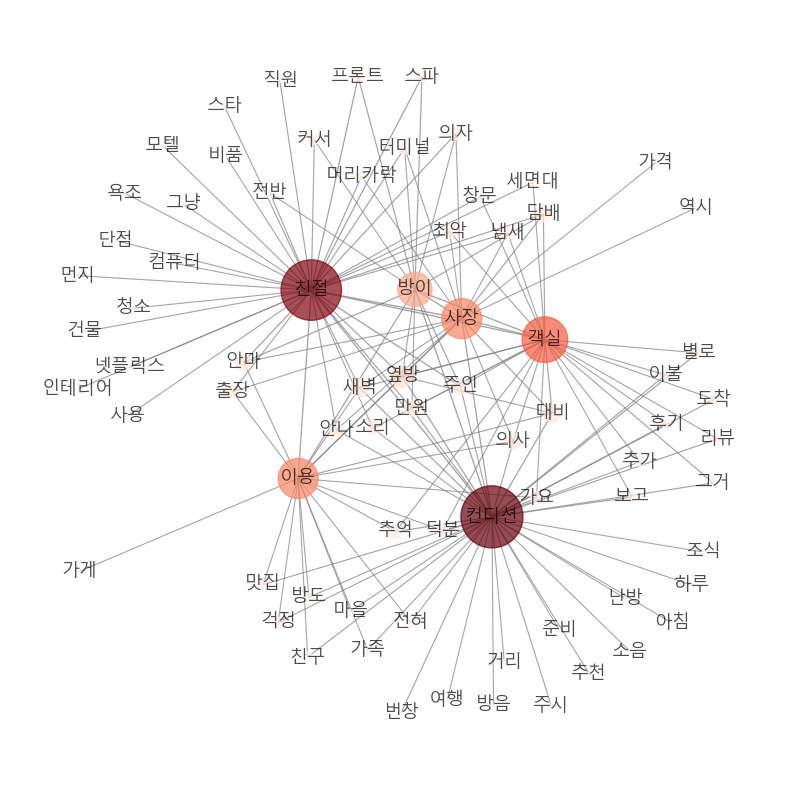

In [89]:
# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

weights = nx.get_edge_attributes(G_2223,'weight').values()
width = [weight / max(weights) for weight in weights]
pos = nx.kamada_kawai_layout(G_2223)

plt.figure(figsize = (10,10))
nx.draw_networkx(G_2223, pos=pos, node_size=nsize, node_color = list(pr.values()), \
                font_family="malgun gothic", with_labels=True, font_size=13, alpha = 0.7, \
                edge_color = '.5', cmap = plt.cm.Reds, width=width)
plt.axis("off")
plt.savefig("image/2022-2023 keyword network.png", dpi = 200, bbox_inches = 'tight')
plt.show()

In [90]:
overall(G_2021)

Average Degree: {41: 4.463414634146342, 100: 1.92, 2: 68.02857142857142, 1: 92.46268656716418, 3: 41.0, 5: 29.8, 8: 19.25}
Clustering Coefficient: 0.34553224280008793
Average Path Length: 2.069996602106694
Network Density: 0.0254841997961264
Network Modularity: 9.992007221626409e-16


In [91]:
overall(G_2122)

Average Degree: {86: 2.1511627906976742, 4: 36.75, 5: 29.533333333333335, 3: 45.666666666666664, 7: 22.285714285714285, 2: 58.0, 15: 3.7333333333333334, 1: 82.29629629629629, 10: 7.5, 36: 5.25}
Clustering Coefficient: 0.2513062439279288
Average Path Length: 2.0451145395044414
Network Density: 0.03506311360448808
Network Modularity: 2.220446049250313e-16


In [92]:
overall(G_2223)

Average Degree: {20: 7.9, 38: 4.842105263157895, 41: 3.8780487804878048, 15: 9.6, 26: 5.538461538461538, 4: 26.95, 2: 30.931818181818183, 7: 23.571428571428573, 5: 25.9, 3: 28.566666666666666, 1: 37.37931034482759}
Clustering Coefficient: 0.20285159110781703
Average Path Length: 2.3185585585585584
Network Density: 0.05405405405405406
Network Modularity: 1.1102230246251565e-16
